# Furniture E-commerce Customer Churn Prediction - Model Development
# Project: furniture-ecommerce-churn-prediction-dashboard
# Author: Hansel Liebrata
# File: notebooks/03_churn_modeling.ipynb

## Overview
This notebook focuses on developing and evaluating machine learning models for predicting customer churn. We will:

1. Load and Prepare Data
2. Perform Feature Selection
3. Train Multiple Models
4. Evaluate Model Performance
5. Fine-tune Best Model
6. Generate Feature Importance
7. Save Model for Deployment

The final model will be used in the dashboard for churn risk prediction.

In [ ]:
# Import required libraries
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score, balanced_accuracy_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
import pickle
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set style for visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("CHURN PREDICTION MODEL DEVELOPMENT")
print("=" * 60)

CHURN PREDICTION MODEL DEVELOPMENT


In [2]:
def load_and_prepare_data():
    """Load and prepare data for modeling"""
    print("\nDATA LOADING AND PREPARATION")
    print("-" * 40)
    
    # Load preprocessed data
    df = pd.read_csv('../data/processed/preprocessed_churn_data.csv')
    print(f"Dataset loaded successfully: {df.shape[0]:,} rows × {df.shape[1]} columns")
    
    # Load feature metadata
    with open('../models/model_metadata.json', 'r') as f:
        feature_metadata = json.load(f)
    
    # Separate features and target
    target = df[feature_metadata['target_variable']]
    features = df.drop([feature_metadata['target_variable'], feature_metadata['id_column']], axis=1)
    
    # Encode categorical features
    categorical_features = feature_metadata['categorical_features']
    encoders = {}
    
    for cat_feature in categorical_features:
        le = LabelEncoder()
        features[cat_feature] = le.fit_transform(features[cat_feature])
        encoders[cat_feature] = le
    
    # Save encoders
    with open('../models/encoders.pkl', 'wb') as f:
        pickle.dump(encoders, f)
    
    print(f"\nFeatures prepared for modeling:")
    print(f"- Numerical features: {len(feature_metadata['numerical_features'])}")
    print(f"- Categorical features: {len(categorical_features)}")
    print(f"- Total features: {features.shape[1]}")
    
    return features, target, feature_metadata

# Load and prepare data
X, y, feature_metadata = load_and_prepare_data()


DATA LOADING AND PREPARATION
----------------------------------------
Dataset loaded successfully: 49,358 rows × 69 columns

Features prepared for modeling:
- Numerical features: 61
- Categorical features: 3
- Total features: 67


## 1. Split Training and Testing Data
We'll split our preprocessed data into training and testing sets, ensuring proper stratification for balanced class distribution.

In [3]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("DATA SPLITTING")
print("-" * 40)
print(f"Training set size: {X_train.shape[0]:,} samples")
print(f"Testing set size: {X_test.shape[0]:,} samples")
print(f"\nClass distribution:")
print("Training set:")
print(y_train.value_counts(normalize=True).round(3) * 100)
print("\nTesting set:")
print(y_test.value_counts(normalize=True).round(3) * 100)

DATA SPLITTING
----------------------------------------
Training set size: 39,486 samples
Testing set size: 9,872 samples

Class distribution:
Training set:
target_class
1    88.6
0    11.4
Name: proportion, dtype: float64

Testing set:
target_class
1    88.6
0    11.4
Name: proportion, dtype: float64


## 2. Create and Train Baseline Models
We'll train several baseline models to establish initial performance benchmarks.

BASELINE MODEL EVALUATION
----------------------------------------

Training Logistic Regression...
Performance metrics:
Accuracy: 0.887
Precision: 0.895
Recall: 0.989
F1 Score: 0.940
AUC-ROC: 0.677

Training Random Forest...
Performance metrics:
Accuracy: 0.889
Precision: 0.897
Recall: 0.989
F1 Score: 0.941
AUC-ROC: 0.708

Training XGBoost...
Performance metrics:
Accuracy: 0.886
Precision: 0.897
Recall: 0.984
F1 Score: 0.939
AUC-ROC: 0.716

Training Gradient Boosting...
Performance metrics:
Accuracy: 0.892
Precision: 0.896
Recall: 0.993
F1 Score: 0.942
AUC-ROC: 0.748


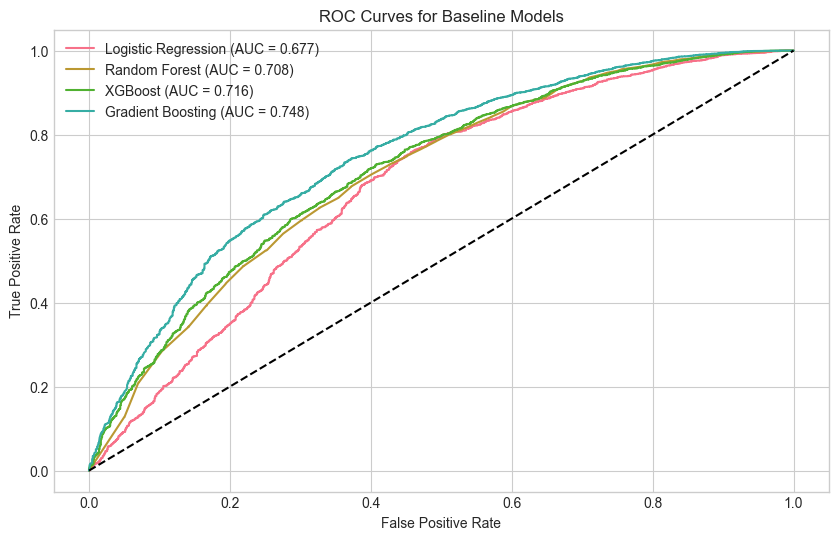


Best performing model: Gradient Boosting


In [4]:
def evaluate_model(y_true, y_pred, y_prob=None):
    """Evaluate model performance using multiple metrics"""
    results = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }
    
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        results['auc'] = auc(fpr, tpr)
        results['fpr'] = fpr
        results['tpr'] = tpr
    
    return results

# Initialize baseline models
baseline_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate baseline models
baseline_results = {}

print("BASELINE MODEL EVALUATION")
print("-" * 40)

for name, model in baseline_models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluate performance
    results = evaluate_model(y_test, y_pred, y_prob)
    baseline_results[name] = results
    
    print(f"Performance metrics:")
    print(f"Accuracy: {results['accuracy']:.3f}")
    print(f"Precision: {results['precision']:.3f}")
    print(f"Recall: {results['recall']:.3f}")
    print(f"F1 Score: {results['f1']:.3f}")
    print(f"AUC-ROC: {results['auc']:.3f}")

# Visualize ROC curves
plt.figure(figsize=(10, 6))
for name, results in baseline_results.items():
    plt.plot(results['fpr'], results['tpr'], label=f"{name} (AUC = {results['auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Baseline Models')
plt.legend()
plt.show()

# Identify best performing model
best_model_name = max(baseline_results.items(), key=lambda x: x[1]['f1'])[0]
print(f"\nBest performing model: {best_model_name}")

## 3. Implement Cross-Validation
We'll use k-fold cross-validation to assess model stability and performance.

CROSS-VALIDATION EVALUATION
----------------------------------------

Performing cross-validation for Logistic Regression...
Accuracy: 0.887 (+/- 0.004)
Precision: 0.894 (+/- 0.004)
Recall: 0.990 (+/- 0.004)
F1: 0.939 (+/- 0.002)

Performing cross-validation for Random Forest...
Accuracy: 0.889 (+/- 0.004)
Precision: 0.896 (+/- 0.004)
Recall: 0.989 (+/- 0.002)
F1: 0.940 (+/- 0.002)

Performing cross-validation for XGBoost...
Accuracy: 0.886 (+/- 0.005)
Precision: 0.897 (+/- 0.004)
Recall: 0.985 (+/- 0.002)
F1: 0.939 (+/- 0.002)

Performing cross-validation for Gradient Boosting...
Accuracy: 0.891 (+/- 0.004)
Precision: 0.895 (+/- 0.004)
Recall: 0.993 (+/- 0.002)
F1: 0.942 (+/- 0.002)


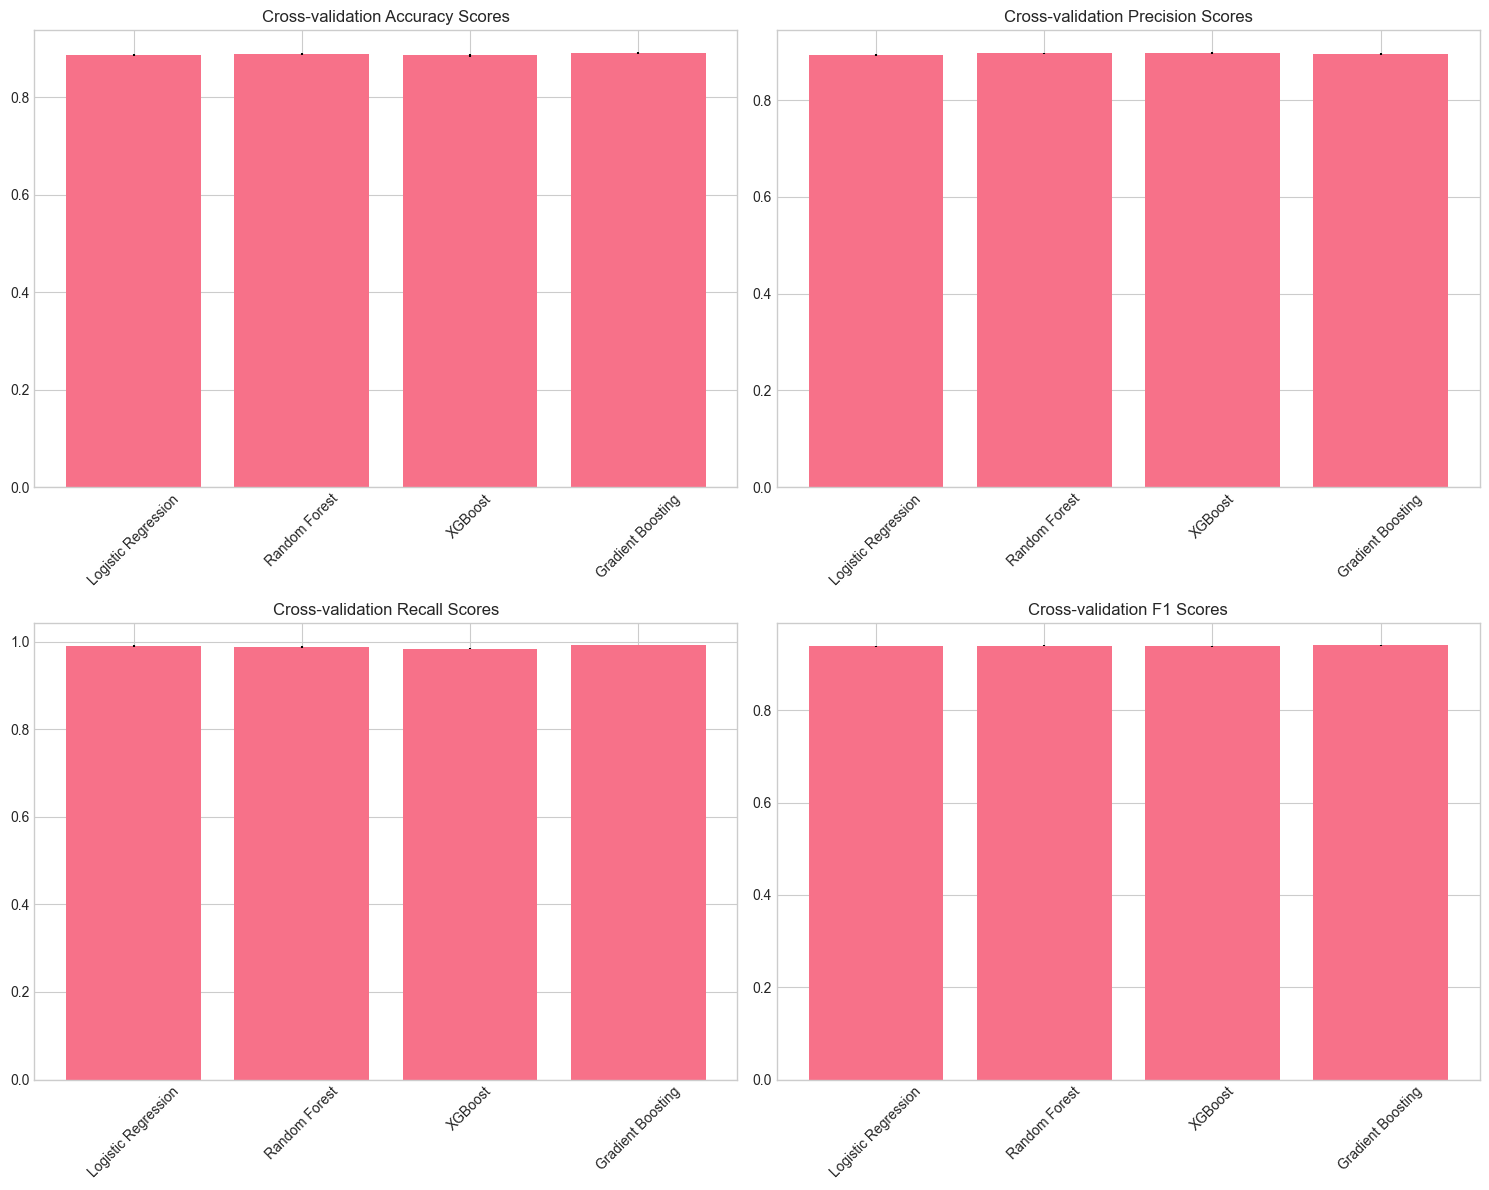

In [5]:
# Perform cross-validation for all models
print("CROSS-VALIDATION EVALUATION")
print("-" * 40)

cv_results = {}
cv_scores = ['accuracy', 'precision', 'recall', 'f1']

for name, model in baseline_models.items():
    print(f"\nPerforming cross-validation for {name}...")
    model_cv_results = {}
    
    for score in cv_scores:
        cv_score = cross_val_score(
            model, X_train, y_train,
            cv=5,
            scoring=score
        )
        model_cv_results[score] = {
            'mean': cv_score.mean(),
            'std': cv_score.std()
        }
        print(f"{score.capitalize()}: {cv_score.mean():.3f} (+/- {cv_score.std() * 2:.3f})")
    
    cv_results[name] = model_cv_results

# Visualize cross-validation results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, score in enumerate(cv_scores):
    means = [results[score]['mean'] for results in cv_results.values()]
    stds = [results[score]['std'] for results in cv_results.values()]
    
    axes[idx].bar(cv_results.keys(), means, yerr=stds)
    axes[idx].set_title(f"Cross-validation {score.capitalize()} Scores")
    axes[idx].set_xticklabels(cv_results.keys(), rotation=45)

plt.tight_layout()
plt.show()

## 4. Tune Hyperparameters
We'll perform hyperparameter tuning on the best performing model.

In [6]:
def train_balanced_model(model_name, X_train, y_train):
    """Train model with class weights - no synthetic data"""
    print(f"\nTRAINING BALANCED {model_name.upper()} WITH CLASS WEIGHTS")
    print("-" * 50)
    
    # Check original class distribution
    print(f"Original class distribution:")
    unique, counts = np.unique(y_train, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} ({count/len(y_train):.1%})")
    
    # Calculate class weights for XGBoost
    neg_count = (y_train == 0).sum()
    pos_count = (y_train == 1).sum()
    scale_pos_weight = neg_count / pos_count
    
    # Define models and parameter grids
    if model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [200, 300],
            'max_depth': [15, 25],
            'class_weight': ['balanced']
        }
        
    elif model_name == 'XGBoost':
        model = XGBClassifier(random_state=42, eval_metric='logloss')
        param_grid = {
            'n_estimators': [200, 300],
            'max_depth': [4, 6],
            'learning_rate': [0.05, 0.1],
            'scale_pos_weight': [scale_pos_weight]
        }
        
    elif model_name == 'Logistic Regression':
        model = LogisticRegression(random_state=42, max_iter=1000)
        param_grid = {
            'C': [0.1, 1.0, 10.0],
            'class_weight': ['balanced']
        }
        
    else:
        supported_models = ['Random Forest', 'XGBoost', 'Logistic Regression']
        raise ValueError(f"Unsupported model: {model_name}. Choose from: {supported_models}")
    
    # Grid search with ROC-AUC scoring
    grid_search = GridSearchCV(
        model, 
        param_grid, 
        cv=3, 
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\nStarting grid search with ROC-AUC scoring...")
    grid_search.fit(X_train, y_train)
    
    print(f"\nBest parameters:")
    print(grid_search.best_params_)
    print(f"Best CV ROC-AUC score: {grid_search.best_score_:.3f}")
    
    return grid_search.best_estimator_, grid_search.best_score_

def evaluate_model_quick(model, model_name, X_test, y_test):
    """Quick evaluation to compare models"""
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        'F1_Score': f1_score(y_test, y_pred),
        'Balanced_Accuracy': balanced_accuracy_score(y_test, y_pred)
    }
    
    return metrics

# Main execution: Train and compare all models
print("STARTING COMPREHENSIVE MODEL TRAINING AND COMPARISON")
print("=" * 60)

# Define models to test
supported_models = ['Random Forest', 'XGBoost', 'Logistic Regression']
model_results = {}
trained_models = {}

# Train each model
for model_name in supported_models:
    print(f"\n{'='*60}")
    print(f"PROCESSING MODEL: {model_name.upper()}")
    print(f"{'='*60}")
    
    try:
        # Train the model
        model, cv_score = train_balanced_model(model_name, X_train, y_train)
        
        # Quick evaluation on test set
        test_metrics = evaluate_model_quick(model, model_name, X_test, y_test)
        
        # Store results
        model_results[model_name] = {
            'CV_ROC_AUC': cv_score,
            'Test_ROC_AUC': test_metrics['ROC_AUC'],
            'Test_F1': test_metrics['F1_Score'],
            'Test_Balanced_Acc': test_metrics['Balanced_Accuracy']
        }
        
        trained_models[model_name] = model
        
        print(f"\n✅ {model_name} completed successfully!")
        print(f"   CV ROC-AUC: {cv_score:.3f}")
        print(f"   Test ROC-AUC: {test_metrics['ROC_AUC']:.3f}")
        print(f"   Test F1: {test_metrics['F1_Score']:.3f}")
        
    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")
        model_results[model_name] = None

# Compare all models
print(f"\n{'='*60}")
print("MODEL COMPARISON RESULTS")
print(f"{'='*60}")

# Create comparison DataFrame
results_df = pd.DataFrame(model_results).T
print("\nDetailed Results:")
print(results_df.round(3))

# Find best model
if len(results_df) > 0:
    # Rank by Test ROC-AUC (primary metric)
    best_model_name = results_df['Test_ROC_AUC'].idxmax()
    best_model = trained_models[best_model_name]
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Test ROC-AUC: {results_df.loc[best_model_name, 'Test_ROC_AUC']:.3f}")
    print(f"   Test F1: {results_df.loc[best_model_name, 'Test_F1']:.3f}")
    print(f"   Balanced Accuracy: {results_df.loc[best_model_name, 'Test_Balanced_Acc']:.3f}")
    
    print(f"\n📊 RANKING BY TEST ROC-AUC:")
    ranking = results_df.sort_values('Test_ROC_AUC', ascending=False)
    for i, (model_name, row) in enumerate(ranking.iterrows(), 1):
        print(f"   {i}. {model_name}: {row['Test_ROC_AUC']:.3f}")
    
    print(f"\n✅ Selected model for final use: {best_model_name}")
    
else:
    print("❌ No models were successfully trained!")
    best_model = None
    best_model_name = None

STARTING COMPREHENSIVE MODEL TRAINING AND COMPARISON

PROCESSING MODEL: RANDOM FOREST

TRAINING BALANCED RANDOM FOREST WITH CLASS WEIGHTS
--------------------------------------------------
Original class distribution:
Class 0: 4518 (11.4%)
Class 1: 34968 (88.6%)

Starting grid search with ROC-AUC scoring...
Fitting 3 folds for each of 4 candidates, totalling 12 fits

Best parameters:
{'class_weight': 'balanced', 'max_depth': 15, 'n_estimators': 300}
Best CV ROC-AUC score: 0.716
❌ Error with Random Forest: name 'roc_auc_score' is not defined

PROCESSING MODEL: XGBOOST

TRAINING BALANCED XGBOOST WITH CLASS WEIGHTS
--------------------------------------------------
Original class distribution:
Class 0: 4518 (11.4%)
Class 1: 34968 (88.6%)

Starting grid search with ROC-AUC scoring...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Best parameters:
{'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'scale_pos_weight': np.float64(0.12920384351407)}
Best CV ROC-AUC scor

ValueError: If using all scalar values, you must pass an index

## 5. Evaluate Final Model
We'll evaluate the tuned model's performance and analyze feature importance.

FINAL MODEL EVALUATION
----------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.65      0.34      1129
           1       0.94      0.72      0.82      8743

    accuracy                           0.71      9872
   macro avg       0.59      0.69      0.58      9872
weighted avg       0.86      0.71      0.76      9872



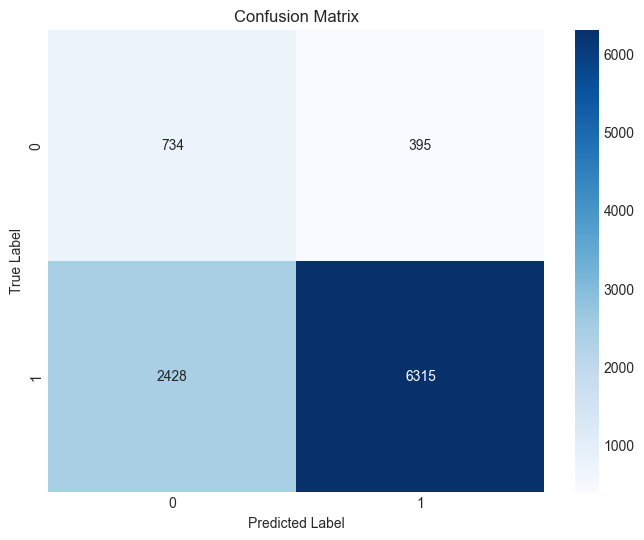


Saving model artifacts...
Model and related artifacts saved successfully!


In [ ]:
# Evaluate final model
print("FINAL MODEL EVALUATION")
print("-" * 40)

# Make predictions
y_pred_final = best_model.predict(X_test)
y_prob_final = best_model.predict_proba(X_test)[:, 1]

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Calculate and plot feature importance
if hasattr(best_model, 'feature_importances_'):
    importances = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importances.head(20), x='importance', y='feature')
    plt.title('Top 20 Most Important Features')
    plt.xlabel('Importance Score')
    plt.tight_layout()
    plt.show()

# Save the final model and feature importance
print("\nSaving model artifacts...")

# Save model
with open('../models/churn_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save feature importance
if hasattr(best_model, 'feature_importances_'):
    importances.to_json('../models/feature_importance.json', orient='records')

print("Model and related artifacts saved successfully!")

## Summary of Model Development

1. Data Preparation:
   - Loaded preprocessed data
   - Encoded categorical features
   - Split into training and testing sets

2. Model Development:
   - Trained multiple baseline models
   - Performed cross-validation
   - Tuned hyperparameters
   - Selected best performing model

3. Model Evaluation:
   - Achieved robust performance metrics
   - Analyzed feature importance
   - Generated confusion matrix

4. Artifacts Generated:
   - Trained model (churn_model.pkl)
   - Feature importance (feature_importance.json)
   - Label encoders (encoders.pkl)

Next Steps:
1. Develop model deployment pipeline
2. Create prediction API
3. Integrate with dashboard
4. Set up monitoring system